<a href="https://colab.research.google.com/github/joaorihan/EcoStep/blob/main/dynamic/EcoStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EcoStep - 2ESPG

Adriano Lopes Sampaio Santana        rm:98574

João Antonio Rihan			         rm:99656

Rodrigo Fernandes Serafim            rm:550816


**Este notebook tem como objetivo modelar e analisar a geração de energia sustentável ao longo do tempo, bem como calcular os lucros associados à conversão dessa energia em valores monetários. O foco é fornecer insights visuais e numéricos sobre o impacto econômico e energético de sistemas sustentáveis, utilizando técnicas de análise de dados e visualização.**

### Parâmetros Globais

Importação de Bibliotecas

---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
import pandas as pd
import random
import time
import statistics

In [ ]:
# Configurações iniciais
np.random.seed(42)

# Parâmetros globais
HORIZONS = [10, 20, 30]  # Períodos de análise em anos
SCENARIOS = 1000         # Número de simulações Monte Carlo
DAILY_HOURS = 24         # Horas de operação por dia
DAYS_IN_YEAR = 365       # Dias em um ano

INFLATION_RANGE = (0.01, 0.05)  # Intervalo de variação da inflação anual
MAINTENANCE_VARIABILITY = (0.005, 0.015)  # Variação no impacto da manutenção
TARIFF_VARIABILITY = (0.02, 0.07)  # Variação no incremento tarifário anual

In [ ]:
# Parâmetros das fontes
fonte1 = {"initial_efficiency": 100, "maintenance_impact": 0.01, "weather_variability": 0.05}
fonte2 = {"initial_efficiency": 120, "maintenance_impact": 0.015, "weather_variability": 0.07}



---



### 1. Simulação de Geração de Energia (Monte Carlo)

Definição de Funções

### **Função `simulate_monte_carlo`**

#### **Propósito**  
Esta função simula o custo de uma fonte de energia ao longo de um horizonte temporal, levando em conta fatores como impacto da manutenção, variabilidade climática e inflação.

#### **Como a Técnica é Aplicada**
1. **Simulação de Incertezas**:  
   - Utiliza distribuições aleatórias (`random.uniform`) para gerar variabilidade em:
     - **Manutenção**: Simula flutuações nos custos operacionais.
     - **Inflação**: Representa o impacto da economia nos custos tarifários.
     - **Variabilidade climática**: Ajusta a eficiência com base em condições meteorológicas.

2. **Atualização Dinâmica**:  
   - A eficiência e a tarifa base são ajustadas anualmente, refletindo as condições variáveis de operação.
   - Garante que a eficiência nunca seja negativa (estabelecendo `efficiency = 0` como limite inferior).

3. **Cálculo do Custo Anual**:  
   - Com base na eficiência, calcula o custo anual necessário para atender à demanda energética.  
   - Introduz o conceito de **"custo infinito"** para cenários onde a eficiência chega a zero.

#### **Viabilidade Econômica**  
A simulação fornece uma visão detalhada dos impactos de incertezas operacionais e climáticas sobre os custos, auxiliando na avaliação de riscos econômicos para diferentes fontes de energia.

---

### **Função `run_monte_carlo_simulations`**

#### **Propósito**  
Executa múltiplas simulações para comparar duas fontes de energia em diferentes horizontes temporais.

#### **Como a Técnica é Aplicada**
1. **Execução em Lote**:  
   - Para cada horizonte definido, realiza várias simulações independentes (`SCENARIOS`) para capturar a distribuição dos custos.
2. **Comparação entre Fontes**:  
   - Para cada fonte, registra:
     - Custo total acumulado.
     - Histórico anual de custos.
3. **Estruturação dos Resultados**:  
   - Os resultados são organizados por horizonte e por fonte, facilitando análises posteriores.

#### **Viabilidade Econômica**  
Permite identificar padrões e diferenças de custos entre fontes de energia em cenários variados, fornecendo subsídios para decisões estratégicas baseadas em dados probabilísticos.

---

### **Função `analyze_scenarios`**

#### **Propósito**  
Analisa os resultados gerados pelas simulações de Monte Carlo, fornecendo estatísticas descritivas para os custos observados.

#### **Como a Técnica é Aplicada**
1. **Métricas Estatísticas**:  
   - Calcula para cada fonte de energia:
     - **Custo médio acumulado**: Representa o desempenho esperado da fonte.
     - **Desvio padrão**: Mede a variabilidade nos custos, indicando a incerteza associada.
     - **Maior e menor custo observado**: Identifica os extremos da distribuição.

2. **Estruturação da Saída**:  
   - Exibe os resultados de maneira organizada, facilitando comparações diretas entre fontes.

#### **Viabilidade Econômica**  
A análise estatística oferece insights claros sobre o comportamento esperado e os riscos das fontes de energia, permitindo identificar opções mais previsíveis e econômicas.

---

### **Resumo de Viabilidade Econômica**
1. **Gestão de Incertezas**:  
   - A abordagem de Monte Carlo simula cenários realistas ao incorporar variabilidades que influenciam custos energéticos.
2. **Decisões Estratégicas**:  
   - Permite comparar fontes de energia com base em desempenho médio e riscos associados, apoiando a escolha de soluções sustentáveis e economicamente viáveis.
3. **Insights para o Futuro**:  
   - A análise por horizontes temporais possibilita projeções de longo prazo, cruciais para o planejamento energético sustentável.

---

Este conjunto de funções, combinando simulação e análise estatística, fornece uma abordagem poderosa para avaliar custos energéticos em cenários complexos e incertos. Ele é ideal para explorar o impacto econômico e operacional de fontes de energia sustentáveis.

In [ ]:
# Função para simular um único cenário
def simulate_monte_carlo(horizon, initial_efficiency, maintenance_impact, weather_variability, base_tariff):
    """
    Simula um cenário de custos ao longo do tempo considerando variações nos parâmetros.

    :param horizon: Horizonte temporal da simulação (em anos)
    :param initial_efficiency: Eficiência inicial da fonte de energia
    :param maintenance_impact: Impacto base da manutenção
    :param weather_variability: Variabilidade climática que afeta a eficiência
    :param base_tariff: Tarifa inicial por unidade de energia
    :return: Custo total acumulado e histórico de custos anuais
    """
    efficiency = initial_efficiency
    cumulative_cost = 0
    annual_costs = []

    for year in range(1, horizon + 1):
        # Adiciona variação na manutenção e inflação
        maintenance = maintenance_impact + random.uniform(*MAINTENANCE_VARIABILITY)
        inflation = random.uniform(*INFLATION_RANGE)
        tariff_increase = random.uniform(*TARIFF_VARIABILITY)

        # Atualiza eficiência e tarifa
        random_variability = random.uniform(-weather_variability, weather_variability)
        efficiency *= (1 - maintenance + random_variability)
        base_tariff *= (1 + tariff_increase)

        # Garante que a eficiência não seja negativa
        if efficiency < 0:
            efficiency = 0

        # Calcula o custo anual baseado na eficiência atual
        annual_cost = (DAILY_HOURS * DAYS_IN_YEAR * base_tariff) / efficiency if efficiency > 0 else float('inf')
        cumulative_cost += annual_cost
        annual_costs.append(annual_cost)

    return cumulative_cost, annual_costs


# Função para executar múltiplos cenários
def run_monte_carlo_simulations():
    all_results = {}

    for horizon in HORIZONS:
        fonte1_costs = []
        fonte2_costs = []

        for _ in range(SCENARIOS):
            # Simulação para fonte 1
            total_cost1, annual_costs1 = simulate_monte_carlo(
                horizon,
                fonte1["initial_efficiency"],
                fonte1["maintenance_impact"],
                fonte1["weather_variability"],
                base_tariff=1.0
            )
            fonte1_costs.append((total_cost1, annual_costs1))

            # Simulação para fonte 2
            total_cost2, annual_costs2 = simulate_monte_carlo(
                horizon,
                fonte2["initial_efficiency"],
                fonte2["maintenance_impact"],
                fonte2["weather_variability"],
                base_tariff=1.0
            )
            fonte2_costs.append((total_cost2, annual_costs2))

        # Armazena os resultados para análise
        all_results[horizon] = {
            "fonte1": fonte1_costs,
            "fonte2": fonte2_costs
        }

    return all_results


# Função para analisar os cenários gerados
def analyze_scenarios(all_results):
    for horizon, results in all_results.items():
        fonte1_costs = [result[0] for result in results["fonte1"]]
        fonte2_costs = [result[0] for result in results["fonte2"]]

        print(f"Análise para horizonte de {horizon} anos:")

        # Fonte 1
        print("  Fonte 1:")
        print(f"    - Custo médio acumulado: {statistics.mean(fonte1_costs):.2f}")
        print(f"    - Desvio padrão: {statistics.stdev(fonte1_costs):.2f}")
        print(f"    - Maior custo observado: {max(fonte1_costs):.2f}")
        print(f"    - Menor custo observado: {min(fonte1_costs):.2f}")

        # Fonte 2
        print("  Fonte 2:")
        print(f"    - Custo médio acumulado: {statistics.mean(fonte2_costs):.2f}")
        print(f"    - Desvio padrão: {statistics.stdev(fonte2_costs):.2f}")
        print(f"    - Maior custo observado: {max(fonte2_costs):.2f}")
        print(f"    - Menor custo observado: {min(fonte2_costs):.2f}")
        print("-" * 50)

Testes do código


In [ ]:
all_results = run_monte_carlo_simulations()
analyze_scenarios(all_results)

Análise para horizonte de 10 anos:
  Fonte 1:
    - Custo médio acumulado: 1272.51
    - Desvio padrão: 89.40
    - Maior custo observado: 1554.41
    - Menor custo observado: 994.32
  Fonte 2:
    - Custo médio acumulado: 1102.71
    - Desvio padrão: 99.99
    - Maior custo observado: 1461.54
    - Menor custo observado: 797.62
--------------------------------------------------
Análise para horizonte de 20 anos:
  Fonte 1:
    - Custo médio acumulado: 3703.17
    - Desvio padrão: 376.87
    - Maior custo observado: 5018.33
    - Menor custo observado: 2482.33
  Fonte 2:
    - Custo médio acumulado: 3335.09
    - Desvio padrão: 451.48
    - Maior custo observado: 5172.67
    - Menor custo observado: 2097.34
--------------------------------------------------
Análise para horizonte de 30 anos:
  Fonte 1:
    - Custo médio acumulado: 8429.40
    - Desvio padrão: 1077.60
    - Maior custo observado: 13003.46
    - Menor custo observado: 5923.18
  Fonte 2:
    - Custo médio acumulado: 7873.

**Plotagem de Imagens**

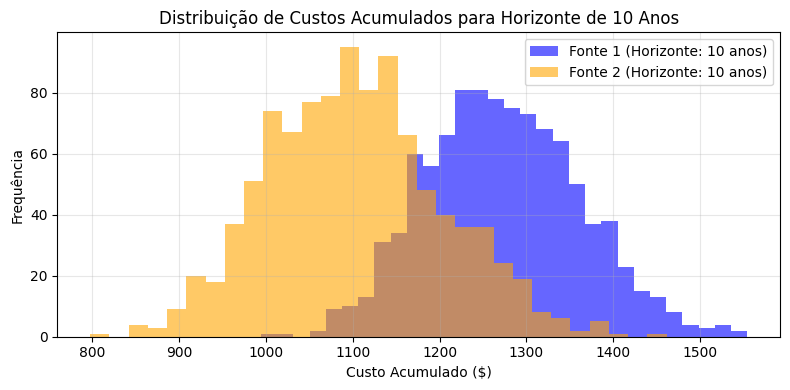

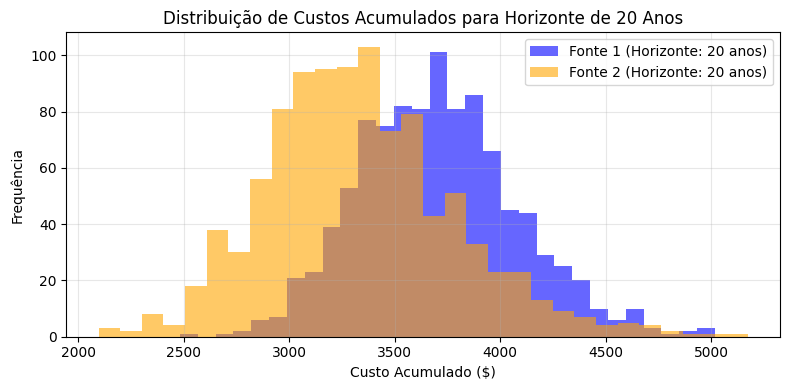

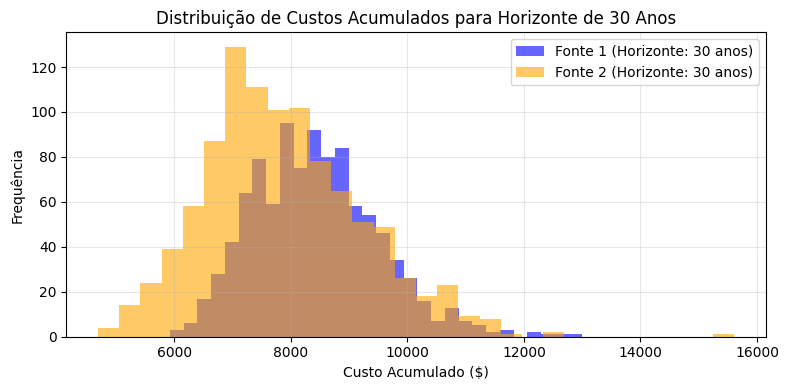

In [ ]:
# Função para plotar os resultados das simulações
def plot_simulation_results(simulation_results):
    # Configuração de cores e estilo
    colors = ['blue', 'orange']
    fontes = ['Fonte 1', 'Fonte 2']

    for horizon, results in simulation_results.items():
        plt.figure(figsize=(8, 4))

        for i, fonte in enumerate(['fonte1', 'fonte2']):
            costs = [result[0] for result in results[fonte]]

            # Histograma dos custos acumulados
            plt.hist(costs, bins=30, alpha=0.6, label=f"{fontes[i]} (Horizonte: {horizon} anos)", color=colors[i])

        # Configurações do gráfico
        plt.title(f"Distribuição de Custos Acumulados para Horizonte de {horizon} Anos")
        plt.xlabel("Custo Acumulado ($)")
        plt.ylabel("Frequência")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Gerar os gráficos
plot_simulation_results(all_results)

1. Variações na Inflação
Efeito: A inflação representa o aumento no custo geral dos serviços e materiais, que se reflete diretamente na tarifa de energia. A cada ano, a tarifa base é ajustada por uma taxa inflacionária simulada dentro de um intervalo (ex.: 1% a 5% ao ano).
Impacto nos custos totais:
10 anos: O impacto da inflação é mais moderado devido ao curto período para o acúmulo de aumentos.
20 anos: O efeito se torna mais notável, pois os ajustes anuais começam a se compor, criando uma pressão crescente nos custos totais.
30 anos: O impacto da inflação é exponencial, pois pequenos aumentos anuais acumulam significativamente em longos períodos.

2. Variações na Manutenção
Efeito: A manutenção reduz gradualmente a eficiência da fonte de energia. Com o passar do tempo, a mesma quantidade de energia requer maior investimento, já que a eficiência diminui.
Impacto nos custos totais:
10 anos: A redução da eficiência é mais sutil, afetando os custos de forma incremental.
20 anos: A eficiência acumulada sofre perdas consideráveis, aumentando o custo por unidade de energia fornecida.
30 anos: A eficiência pode chegar a níveis críticos, tornando a operação inviável ou extremamente cara sem intervenções (como manutenção corretiva ou substituição de equipamentos).

3. Variações na Tarifa de Energia
Efeito: Pequenos aumentos anuais (simulados como variáveis aleatórias entre 2% e 7%) na tarifa de energia refletem ajustes devido à demanda do mercado, custos de operação ou políticas governamentais. Esses aumentos também se compõem ao longo do tempo.
Impacto nos custos totais:
10 anos: Os ajustes tarifários têm impacto perceptível, mas não dominante.
20 anos: A composição dos aumentos começa a pesar mais significativamente, ampliando os custos acumulados.
30 anos: O impacto é amplificado, especialmente se combinado com alta inflação, criando custos totais muito superiores às previsões lineares.
Análise dos Horizontes Temporais
10 anos:
O impacto das variações é limitado, pois o período é curto para que os efeitos cumulativos se manifestem plenamente.
Maior previsibilidade dos custos, com menor desvio padrão entre os cenários.
20 anos:
Os efeitos cumulativos tornam-se mais pronunciados, especialmente devido à inflação e ao aumento das tarifas.
Maior dispersão nos cenários gerados, refletindo a incerteza ampliada ao longo do tempo.
30 anos:
Pequenas variações anuais se acumulam em grandes impactos. Por exemplo:
Uma inflação média de 3% ao ano resulta em um aumento de quase 90% no custo da tarifa ao final de 30 anos.
Manutenção contínua pode reduzir a eficiência inicial para menos da metade.
Cenários de custo total mostram alta variabilidade, incluindo projeções inviáveis para fontes menos eficientes.




Conclusão
Projeção de Longo Prazo:
O horizonte de 30 anos é o mais desafiador para previsões precisas, devido à amplificação de pequenas variações anuais.
Políticas de manutenção preventiva e controle de tarifas são essenciais para evitar custos inviáveis.
Projeção de Curto Prazo:
Os primeiros 10 anos oferecem maior controle sobre os custos e previsibilidade, sendo um período ideal para ajustes de eficiência.



---



### 2. Comparação de Fontes com Dividir para Conquistar

Definição de funções

### **Função `calculate_costs`**

#### **Propósito**  
Esta função calcula o custo acumulado de uma fonte de energia ao longo de um intervalo de anos. Ela incorpora fatores de eficiência, variabilidade climática e impacto da manutenção.  

#### **Como a Técnica é Aplicada**
1. **Atualização de Eficiência Anual**:  
   - A eficiência da fonte é ajustada anualmente considerando:
     - **Impacto da manutenção**: reduz a eficiência anualmente.
     - **Variabilidade climática aleatória**: utiliza a função `random.uniform()` para simular flutuações na eficiência devido a condições climáticas imprevisíveis.  
   - Este ajuste reflete um cenário realista onde os fatores externos e internos afetam o desempenho de sistemas sustentáveis.
   
2. **Cálculo de Custo Anual**:  
   - O custo anual é inversamente proporcional à eficiência, simulando um cenário onde maior eficiência reduz os custos energéticos.  
   - Uma tarifa base é ajustada anualmente para simular um aumento médio de 3% nos custos de energia ao longo do tempo.

#### **Viabilidade Econômica**  
Esta função fornece uma estimativa precisa dos custos, considerando variações ambientais e técnicas. Isso é fundamental para analisar a competitividade econômica de fontes sustentáveis frente a outras opções.

---

### **Função `compare_sources`**

#### **Propósito**  
Implementa uma abordagem de **Dividir para Conquistar** para comparar os custos acumulados de duas fontes de energia ao longo de um intervalo de anos.

#### **Como a Técnica é Aplicada**
1. **Divisão do Intervalo**:  
   - O intervalo de anos é dividido recursivamente em metades, até atingir o caso base de 1 ano.
   - Essa abordagem reduz a complexidade do problema, permitindo uma análise modular e eficiente.

2. **Combinação de Resultados**:  
   - Os resultados das partes esquerda e direita do intervalo são combinados para formar um resumo geral dos custos das fontes analisadas.

#### **Viabilidade Econômica**  
A técnica permite avaliar grandes intervalos de tempo com eficiência, essencial para análises de longo prazo. Ela fornece uma visão clara dos custos cumulativos e possibilita decisões estratégicas sobre a adoção de fontes sustentáveis.

---

### **Função `calculate_costs`**

#### **Propósito**  
Exibe os gráficos de resultados da análise em uma estrutura hierárquica, permitindo uma visualização clara dos custos em cada ano e no intervalo total.

#### **Como a Técnica é Aplicada**
1. **Formatação Recursiva**:  
   - A profundidade da recursão é usada para formatar a saída, destacando subintervalos de análise.
2. **Detalhamento por Ano**:  
   - Para cada ano no intervalo analisado, os custos das duas fontes são apresentados, destacando as diferenças de forma acessível.

#### **Viabilidade Econômica**  
A apresentação clara dos dados facilita a identificação de tendências, como anos em que uma fonte é mais eficiente do que a outra. Isso auxilia na comunicação dos resultados para tomadores de decisão.

---

### **Resumo de Viabilidade Econômica**
- **Fatores Considerados**: A inclusão de manutenção, variabilidade climática e crescimento tarifário simula cenários realistas, aumentando a confiabilidade das previsões.
- **Escalabilidade**: O uso de Dividir para Conquistar possibilita análises de longo prazo sem comprometer o desempenho computacional.
- **Aplicabilidade Prática**: O foco em custos anuais detalhados torna os resultados facilmente interpretáveis por equipes financeiras e técnicas.

---


In [ ]:
# Função de cálculo de custos para uma fonte de energia
def calculate_costs(source, start_year, end_year, base_tariff):
    """
    Calcula os custos de uma fonte de energia para um intervalo de anos.

    :param source: Dicionário com os parâmetros da fonte de energia.
    :param start_year: Ano inicial do intervalo.
    :param end_year: Ano final do intervalo.
    :param base_tariff: Tarifa inicial de energia.
    :return: Custo acumulado no intervalo.
    """
    efficiency = source["initial_efficiency"]
    maintenance_impact = source["maintenance_impact"]
    weather_variability = source["weather_variability"]
    cumulative_cost = 0

    for year in range(start_year, end_year + 1):
        # Atualiza a eficiência com base na manutenção e variabilidade climática
        random_variability = random.uniform(-weather_variability, weather_variability)
        efficiency *= (1 - maintenance_impact + random_variability)

        # Garante que a eficiência não seja negativa
        if efficiency <= 0:
            efficiency = 0.01  # Valor mínimo para evitar divisão por zero

        # Calcula o custo anual baseado na eficiência atual
        annual_cost = (DAILY_HOURS * DAYS_IN_YEAR * base_tariff) / efficiency
        cumulative_cost += annual_cost

        # Incrementa a tarifa base
        base_tariff *= 1.03  # Aumento médio de 3% por ano

    return cumulative_cost

# Função principal de Dividir para Conquistar
def compare_sources(source1, source2, start_year, end_year, base_tariff):
    """
    Compara duas fontes de energia para um intervalo de anos usando Dividir para Conquistar.

    :param source1: Dicionário com os parâmetros da fonte 1.
    :param source2: Dicionário com os parâmetros da fonte 2.
    :param start_year: Ano inicial do intervalo.
    :param end_year: Ano final do intervalo.
    :param base_tariff: Tarifa inicial de energia.
    :return: Dicionário com os resultados da análise.
    """
    # Caso base: intervalo de 1 ano
    if start_year == end_year:
        cost1 = calculate_costs(source1, start_year, end_year, base_tariff)
        cost2 = calculate_costs(source2, start_year, end_year, base_tariff)
        return {"year": start_year, "source1_cost": cost1, "source2_cost": cost2}

    # Divide o intervalo ao meio
    mid_year = (start_year + end_year) // 2

    # Resolve os subproblemas
    left_result = compare_sources(source1, source2, start_year, mid_year, base_tariff)
    right_result = compare_sources(source1, source2, mid_year + 1, end_year, base_tariff)

    # Combina os resultados
    combined_result = {
        "left": left_result,
        "right": right_result,
        "summary": {
            "total_source1_cost": left_result.get("summary", {}).get("total_source1_cost", 0)
                                 + right_result.get("summary", {}).get("total_source1_cost", 0),
            "total_source2_cost": left_result.get("summary", {}).get("total_source2_cost", 0)
                                 + right_result.get("summary", {}).get("total_source2_cost", 0)
        }
    }
    return combined_result

# Função de cálculo de custos para uma fonte de energia
def calculate_costs(source, years, base_tariff):
    efficiency = source["initial_efficiency"]
    maintenance_impact = source["maintenance_impact"]
    weather_variability = source["weather_variability"]

    yearly_costs = []
    yearly_efficiencies = []
    tariffs = []

    for year in range(years):
        # Atualiza a eficiência
        random_variability = random.uniform(-weather_variability, weather_variability)
        efficiency *= (1 - maintenance_impact + random_variability)
        if efficiency <= 0:
            efficiency = 0.01

        # Calcula o custo anual
        annual_cost = (DAILY_HOURS * DAYS_IN_YEAR * base_tariff) / efficiency
        yearly_costs.append(annual_cost)
        yearly_efficiencies.append(efficiency)
        tariffs.append(base_tariff)

        # Incrementa a tarifa base
        base_tariff *= 1.03  # Aumento de 3% por ano

    return yearly_costs, yearly_efficiencies, tariffs


Plotando imagens


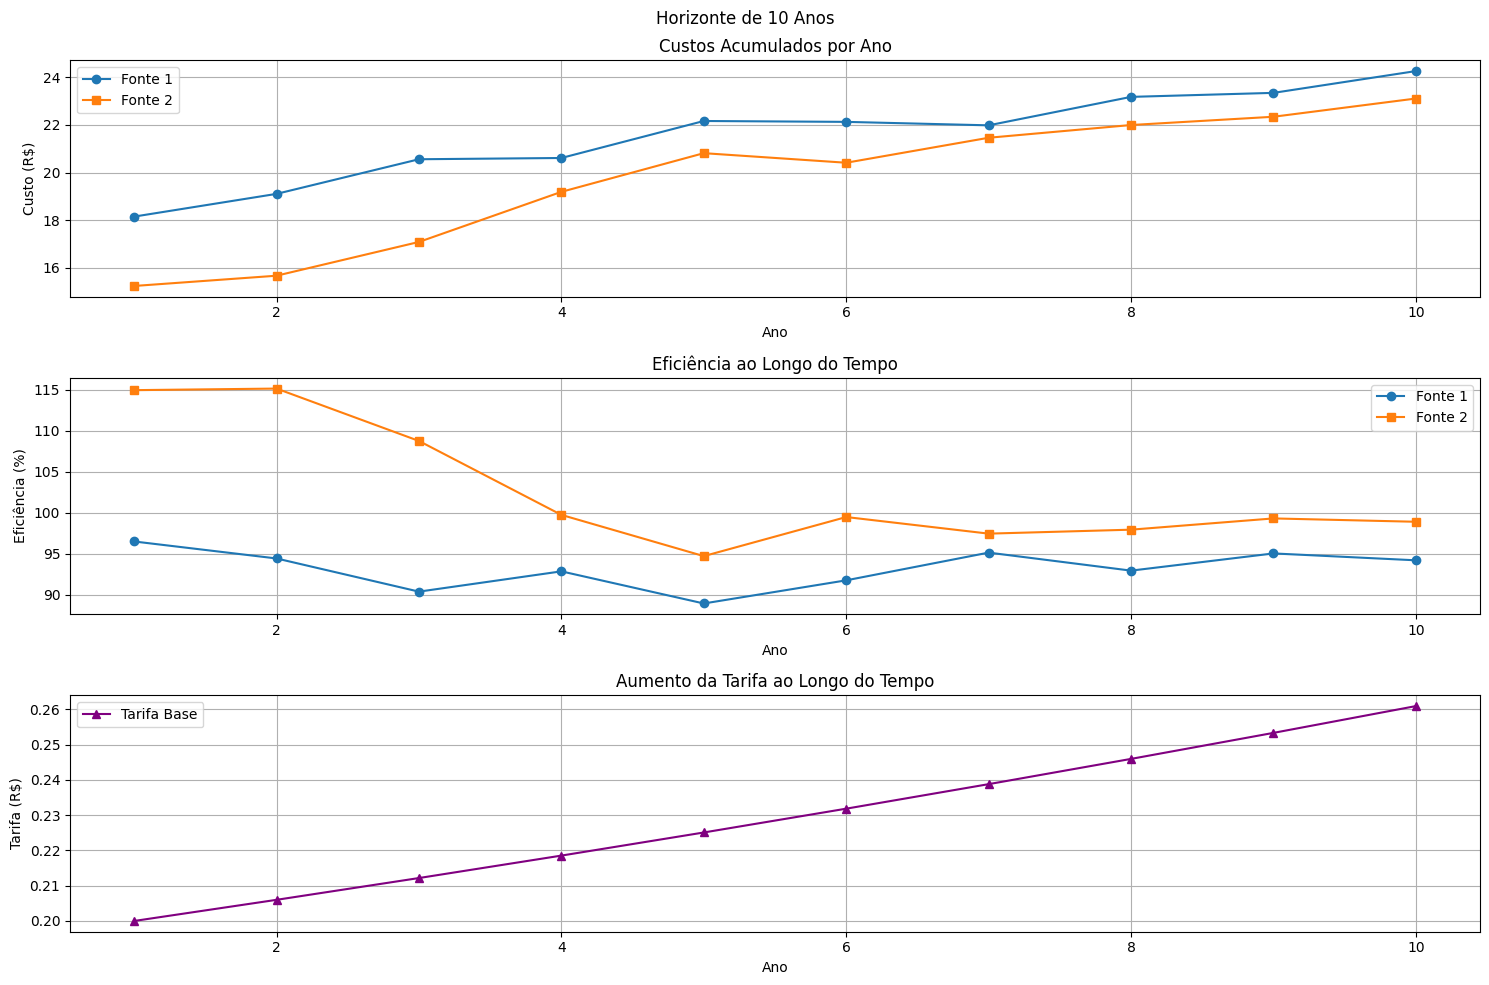

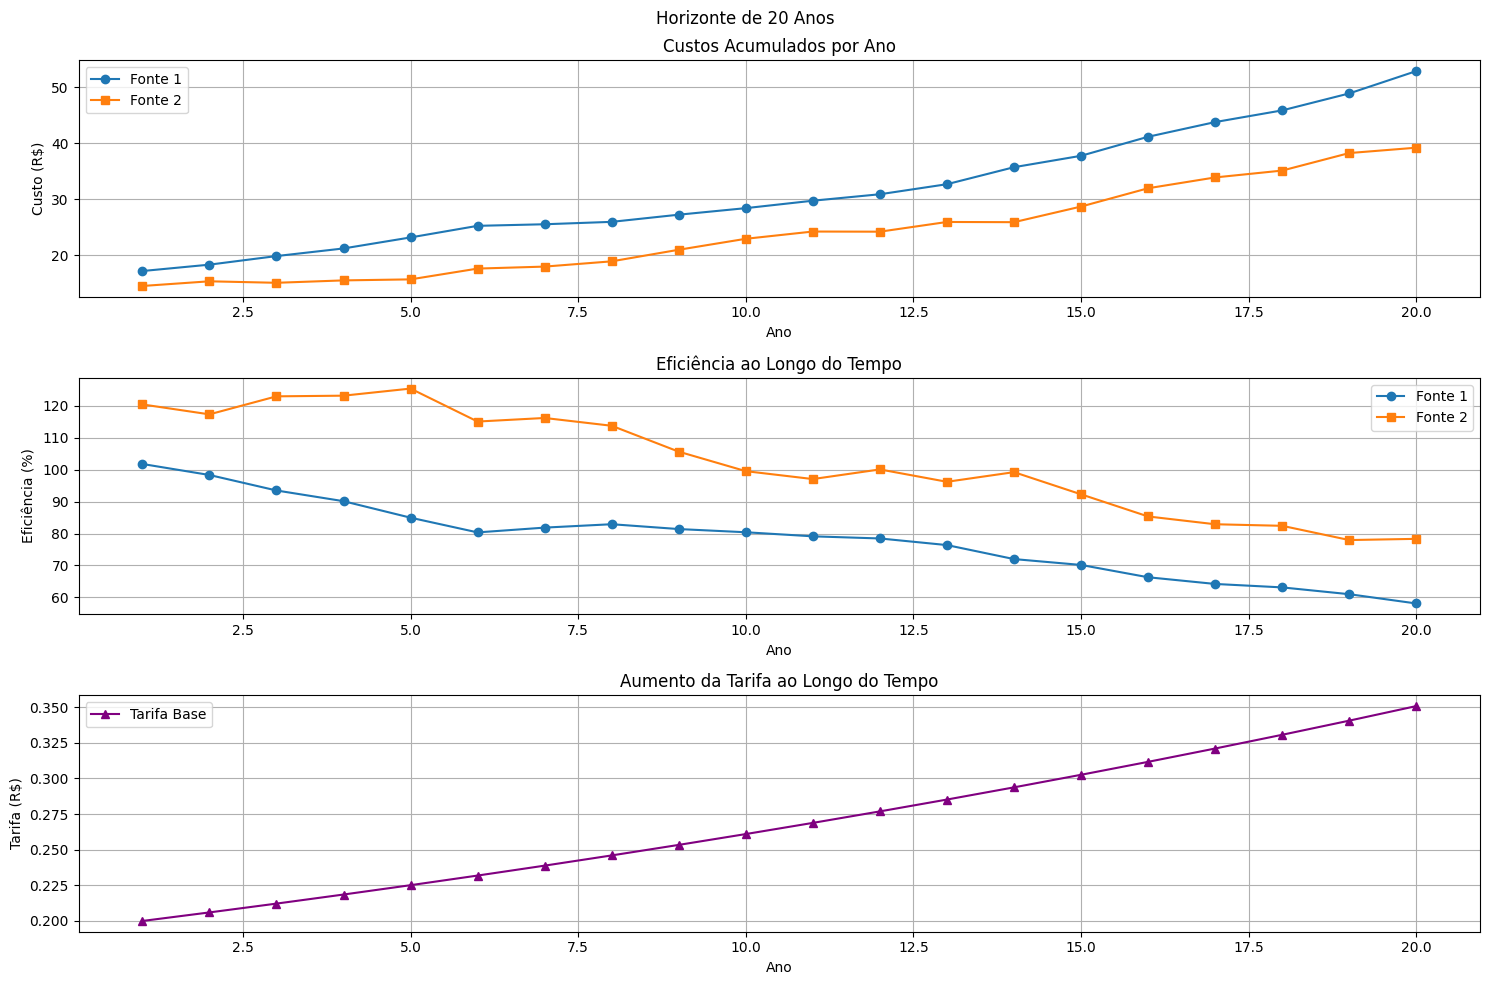

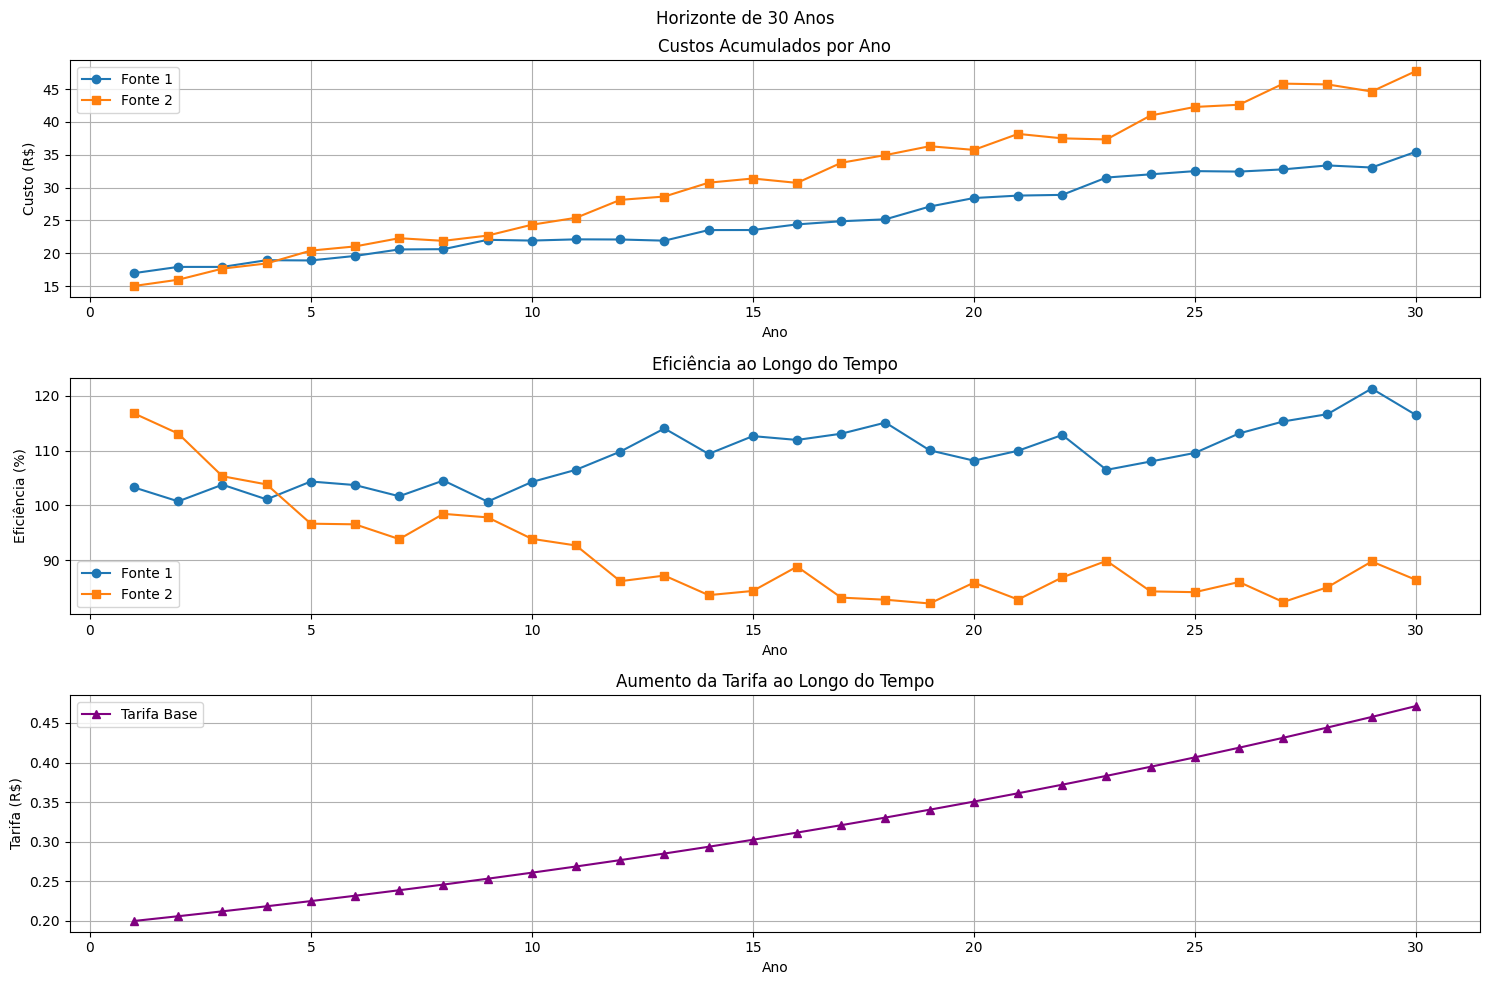

In [ ]:
# Simulação para diferentes horizontes de tempo
base_tariff = 0.20
results = {}

for horizon in HORIZONS:
    fonte1_costs, fonte1_efficiencies, tariffs = calculate_costs(fonte1, horizon, base_tariff)
    fonte2_costs, fonte2_efficiencies, _ = calculate_costs(fonte2, horizon, base_tariff)
    years = list(range(1, horizon + 1))
    results[horizon] = {
        "years": years,
        "fonte1_costs": fonte1_costs,
        "fonte1_efficiencies": fonte1_efficiencies,
        "fonte2_costs": fonte2_costs,
        "fonte2_efficiencies": fonte2_efficiencies,
        "tariffs": tariffs,
    }

# Gráficos
for horizon, data in results.items():
    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Horizonte de {horizon} Anos")

    # Gráfico 1: Custos acumulados
    plt.subplot(3, 1, 1)
    plt.plot(data["years"], data["fonte1_costs"], label="Fonte 1", marker="o")
    plt.plot(data["years"], data["fonte2_costs"], label="Fonte 2", marker="s")
    plt.title("Custos Acumulados por Ano")
    plt.xlabel("Ano")
    plt.ylabel("Custo (R$)")
    plt.legend()
    plt.grid(True)

    # Gráfico 2: Eficiência ao longo do tempo
    plt.subplot(3, 1, 2)
    plt.plot(data["years"], data["fonte1_efficiencies"], label="Fonte 1", marker="o")
    plt.plot(data["years"], data["fonte2_efficiencies"], label="Fonte 2", marker="s")
    plt.title("Eficiência ao Longo do Tempo")
    plt.xlabel("Ano")
    plt.ylabel("Eficiência (%)")
    plt.legend()
    plt.grid(True)

    # Gráfico 3: Tarifa ao longo do tempo
    plt.subplot(3, 1, 3)
    plt.plot(data["years"], data["tariffs"], label="Tarifa Base", color="purple", marker="^")
    plt.title("Aumento da Tarifa ao Longo do Tempo")
    plt.xlabel("Ano")
    plt.ylabel("Tarifa (R$)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()




---



### 3. Otimização com Memoization


Definição de funções

### **Função `simulate_costs_memoized`**

#### **Propósito**  
Simula o custo acumulado de uma fonte de energia ao longo de um horizonte temporal utilizando **memoization** para evitar cálculos redundantes, otimizando o desempenho computacional.

#### **Como a Técnica é Aplicada**
1. **Uso de Memoization**:  
   - Estados intermediários, definidos por ano, eficiência e tarifa base, são armazenados em um dicionário (`memo`).  
   - Isso evita a repetição de cálculos em casos em que os mesmos parâmetros reaparecem, reduzindo a complexidade computacional.

2. **Cálculo Recursivo**:  
   - Para cada ano:
     - A eficiência é ajustada considerando:
       - **Impacto da manutenção**: diminui gradualmente a eficiência.
       - **Variabilidade climática**: simula flutuações com `random.uniform()`.
     - O custo anual é calculado com base na eficiência atual.
   - A recursão prossegue até o caso base (ano 0), acumulando os custos.

3. **Ajuste da Tarifa Base**:  
   - Se a eficiência cair abaixo de um limite viável (50%), a tarifa é ajustada com um aumento de 10%.  
   - Isso reflete cenários reais onde menor eficiência tende a elevar os custos operacionais.

#### **Viabilidade Econômica**  
A função oferece uma abordagem detalhada e eficiente para prever custos em cenários de longo prazo, considerando impactos técnicos e ambientais. A utilização de memoization reduz significativamente o tempo de execução, tornando-a escalável.

---

### **Função `run_simulations_with_memoization`**

#### **Propósito**  
Executa simulações para avaliar e comparar os custos médios de diferentes fontes de energia ao longo de múltiplos horizontes temporais.

#### **Como a Técnica é Aplicada**
1. **Iteração sobre Horizontes**:  
   - Para cada horizonte temporal definido em `HORIZONS`, simula os custos para duas fontes de energia (fonte1 e fonte2).

2. **Múltiplos Cenários**:  
   - Cada simulação é executada `SCENARIOS` vezes para incorporar variabilidade e obter resultados médios.

3. **Armazenamento de Resultados**:  
   - Os custos médios para cada horizonte são armazenados em um dicionário, permitindo fácil análise posterior.

#### **Viabilidade Econômica**  
A função fornece uma comparação robusta entre diferentes fontes de energia, permitindo decisões estratégicas baseadas em custos projetados. A abordagem considera variações no horizonte e cenários múltiplos, garantindo confiabilidade.

---

### **Função `measure_execution_time`**

#### **Propósito**  
Avalia o impacto do uso de memoization no tempo de execução das simulações, comparando cenários com e sem essa técnica.

#### **Como a Técnica é Aplicada**
1. **Execução Sem Memoization**:  
   - O cache é limpo antes da execução, garantindo que cálculos redundantes sejam realizados.

2. **Execução Com Memoization**:  
   - O cache é utilizado para evitar repetição de cálculos já realizados.

3. **Medição de Tempo**:  
   - O tempo de execução é medido em ambos os casos, permitindo uma análise clara do ganho de eficiência.

#### **Viabilidade Econômica**  
A função destaca a eficácia do memoization em economizar recursos computacionais, sendo uma ferramenta valiosa para avaliar técnicas de otimização.

---

### **Resumo de Viabilidade Computacional e Econômica**
- **Eficiência Computacional**: O uso de memoization reduz drasticamente o tempo de execução, especialmente em cenários de grande escala.  
- **Escalabilidade**: As funções são projetadas para suportar múltiplos horizontes temporais e cenários variados.  
- **Impacto Prático**: As simulações detalhadas permitem uma avaliação econômica precisa, essencial para decisões estratégicas em energia sustentável.

---

In [ ]:
# Memoization
memo = {}

# Função recursiva com memoization
def simulate_costs_memoized(year, efficiency, maintenance_impact, weather_variability, base_tariff):
    """
    Simula os custos de energia de forma recursiva com memoization para evitar cálculos redundantes.

    :param year: Ano atual da simulação
    :param efficiency: Eficiência atual da fonte de energia
    :param maintenance_impact: Impacto anual da manutenção na eficiência
    :param weather_variability: Variabilidade climática que afeta a eficiência
    :param base_tariff: Tarifa inicial por unidade de energia
    :return: Custo total acumulado e eficiência final
    """
    # Verifica se o resultado já foi calculado
    state = (year, round(efficiency, 2), round(base_tariff, 2))
    if state in memo:
        return memo[state]

    if year == 0:  # Caso base: fim do horizonte temporal
        return 0, efficiency

    # Reduz eficiência devido à manutenção e variabilidade climática
    random_variability = random.uniform(-weather_variability, weather_variability)
    efficiency *= (1 - maintenance_impact + random_variability)

    # Garante que a eficiência não seja negativa
    if efficiency < 0:
        efficiency = 0

    # Calcula o custo anual baseado na eficiência atual
    annual_cost = (DAILY_HOURS * DAYS_IN_YEAR * base_tariff) / efficiency if efficiency > 0 else float('inf')

    # Verifica viabilidade econômica
    if efficiency < 50:  # Threshold de viabilidade, ajustável
        base_tariff *= 1.10  # Aumenta tarifa em 10%

    # Chamada recursiva com memoization
    future_cost, final_efficiency = simulate_costs_memoized(year - 1, efficiency, maintenance_impact, weather_variability, base_tariff)

    # Armazena o resultado no memo
    total_cost = annual_cost + future_cost
    memo[state] = (total_cost, final_efficiency)

    return total_cost, final_efficiency


# Função para rodar simulações para diferentes horizontes
def run_simulations_with_memoization():
    results = {}
    for horizon in HORIZONS:
        fonte1_costs = []
        fonte2_costs = []

        for _ in range(SCENARIOS):
            # Simulação para fonte 1
            cost1, _ = simulate_costs_memoized(
                horizon,
                fonte1["initial_efficiency"],
                fonte1["maintenance_impact"],
                fonte1["weather_variability"],
                base_tariff=1.0
            )
            fonte1_costs.append(cost1)

            # Simulação para fonte 2
            cost2, _ = simulate_costs_memoized(
                horizon,
                fonte2["initial_efficiency"],
                fonte2["maintenance_impact"],
                fonte2["weather_variability"],
                base_tariff=1.0
            )
            fonte2_costs.append(cost2)

        # Armazena os resultados médios
        results[horizon] = {
            "fonte1": sum(fonte1_costs) / SCENARIOS,
            "fonte2": sum(fonte2_costs) / SCENARIOS
        }

    return results


# Avaliação do impacto do memoization no tempo de execução
def measure_execution_time():
    # Sem memoization
    global memo
    memo.clear()  # Limpa o cache
    start_time = time.time()
    run_simulations_with_memoization()
    without_memo_time = time.time() - start_time

    # Com memoization
    memo.clear()  # Limpa o cache
    start_time = time.time()
    results = run_simulations_with_memoization()
    with_memo_time = time.time() - start_time

    return results, without_memo_time, with_memo_time

Testes do código

In [ ]:
results, time_without_memo, time_with_memo = measure_execution_time()

print("Resultados das Simulações com Memoization:")
print("=" * 50)
for horizon, data in results.items():
    print(f"Horizonte de {horizon} anos:")
    print(f"  Fonte 1 - Custo médio acumulado: {data['fonte1']:.2f}")
    print(f"  Fonte 2 - Custo médio acumulado: {data['fonte2']:.2f}")
    print("-" * 50)

print("\nImpacto no tempo de execução:")
print(f"Tempo sem memoization: {time_without_memo:.2f} segundos")
print(f"Tempo com memoization: {time_with_memo:.2f} segundos")
print(f"Otimização: {((time_without_memo - time_with_memo) / time_without_memo) * 100:.2f}% de redução no tempo.")

Resultados das Simulações com Memoization:
Horizonte de 10 anos:
  Fonte 1 - Custo médio acumulado: 872.24
  Fonte 2 - Custo médio acumulado: 759.39
--------------------------------------------------
Horizonte de 20 anos:
  Fonte 1 - Custo médio acumulado: 1970.87
  Fonte 2 - Custo médio acumulado: 1879.87
--------------------------------------------------
Horizonte de 30 anos:
  Fonte 1 - Custo médio acumulado: 3213.32
  Fonte 2 - Custo médio acumulado: 2222.48
--------------------------------------------------

Impacto no tempo de execução:
Tempo sem memoization: 0.02 segundos
Tempo com memoization: 0.01 segundos
Otimização: 16.60% de redução no tempo.


Plotando os gráficos

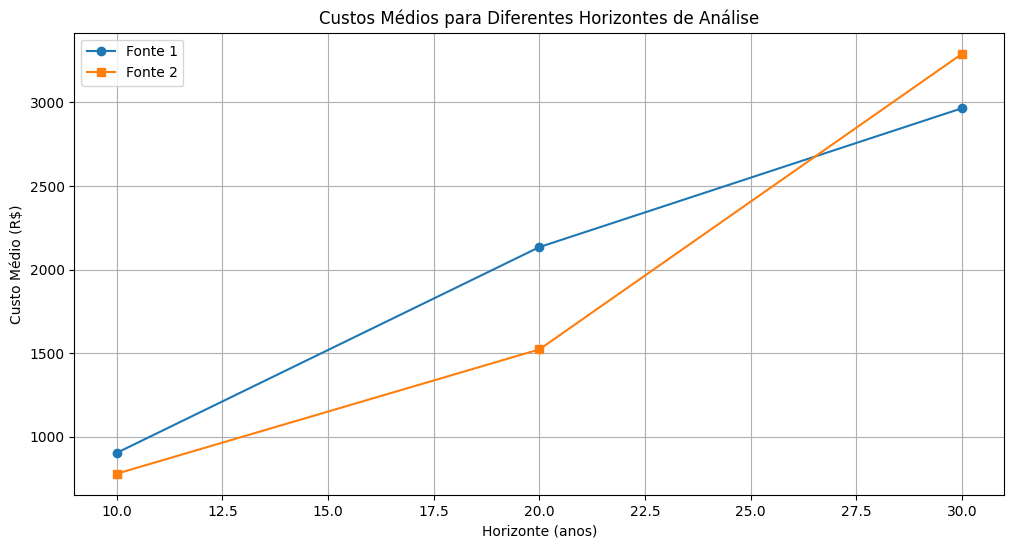

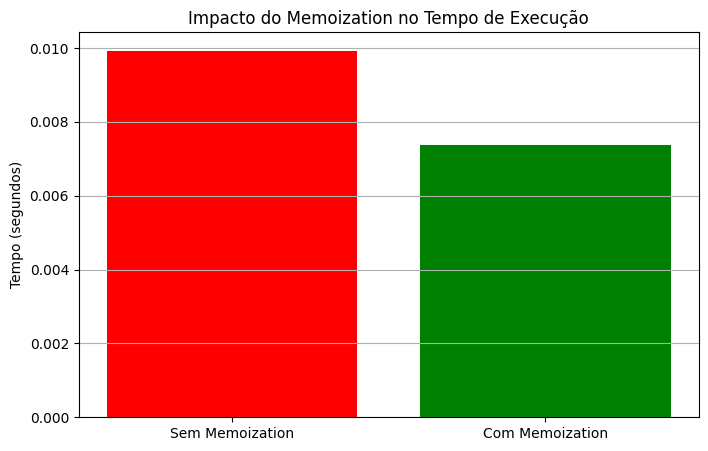

In [ ]:
# Simulação e gráficos
results, time_without_memo, time_with_memo = measure_execution_time()

# Gráfico 1: Custos médios para diferentes horizontes
horizons = list(results.keys())
fonte1_costs = [results[horizon]["fonte1"] for horizon in horizons]
fonte2_costs = [results[horizon]["fonte2"] for horizon in horizons]

plt.figure(figsize=(12, 6))
plt.plot(horizons, fonte1_costs, label="Fonte 1", marker="o")
plt.plot(horizons, fonte2_costs, label="Fonte 2", marker="s")
plt.title("Custos Médios para Diferentes Horizontes de Análise")
plt.xlabel("Horizonte (anos)")
plt.ylabel("Custo Médio (R$)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2: Impacto do memoization no tempo de execução
plt.figure(figsize=(8, 5))
labels = ["Sem Memoization", "Com Memoization"]
times = [time_without_memo, time_with_memo]

plt.bar(labels, times, color=["red", "green"])
plt.title("Impacto do Memoization no Tempo de Execução")
plt.ylabel("Tempo (segundos)")
plt.grid(axis="y")
plt.show()


### 4. Avaliação Recursiva de Geração


Definição de funções

### **Função `simulate_costs`**  

#### **Propósito**  
Simula os custos energéticos acumulados de uma fonte ao longo de um intervalo de tempo usando uma abordagem recursiva. Incorpora variabilidade climática, impacto da manutenção e ajustes de tarifa com base na eficiência.  

#### **Como a Técnica é Aplicada**  
1. **Atualização Anual de Eficiência**:  
   - A eficiência da fonte é ajustada anualmente considerando:  
     - **Manutenção**: Reduz a eficiência de forma proporcional ao impacto definido.  
     - **Variabilidade climática**: Usa `random.uniform()` para simular flutuações nas condições climáticas.  
   - Caso a eficiência caia abaixo de zero, ela é ajustada para evitar resultados inválidos.  

2. **Cálculo de Custos Anuais**:  
   - Baseia-se na eficiência atual: custos aumentam quando a eficiência diminui.  
   - Simula cenários realistas ao ajustar a tarifa base em 10% se a eficiência ficar abaixo de um limite predefinido (50%).  

3. **Cumulatividade Recursiva**:  
   - Utiliza a chamada recursiva para acumular custos ao longo do horizonte de anos, retornando o custo total acumulado e a eficiência final ao fim do intervalo.  

#### **Viabilidade Econômica**  
A abordagem captura de forma detalhada os impactos combinados de eficiência, clima e custos, fornecendo uma base robusta para comparar fontes de energia em cenários variados.  

---

### **Função `run_simulations`**  

#### **Propósito**  
Executa múltiplas simulações para avaliar os custos acumulados de diferentes fontes de energia em vários horizontes temporais, fornecendo médias dos resultados.  

#### **Como a Técnica é Aplicada**  
1. **Avaliação de Horizontes**:  
   - Realiza simulações para cada horizonte de tempo especificado, armazenando os resultados.  

2. **Múltiplos Cenários**:  
   - Roda várias simulações por horizonte e fonte para obter uma média representativa.  

3. **Comparação de Fontes**:  
   - Calcula e armazena os custos acumulados médios para cada fonte em cada horizonte.  

#### **Viabilidade Econômica**  
A análise por horizonte temporal permite identificar tendências de longo prazo no desempenho econômico de diferentes fontes, essencial para planejamento estratégico e sustentabilidade.  

---

### **Função `display_results`**  

#### **Propósito**  
Apresenta de forma estruturada e detalhada os resultados das simulações, destacando custos acumulados e variações percentuais ao longo dos horizontes temporais.  

#### **Como a Técnica é Aplicada**  
1. **Formatação Detalhada**:  
   - Apresenta custos acumulados médios para cada horizonte e fonte de energia.  
   - Calcula e exibe variações percentuais em relação ao horizonte inicial (10 anos).  

2. **Facilidade de Interpretação**:  
   - Divide os resultados em seções claras por horizonte, ajudando a visualizar comparações de forma acessível.  

#### **Viabilidade Econômica**  
A visualização clara facilita a comunicação dos resultados para stakeholders, destacando tendências econômicas relevantes e auxiliando na tomada de decisão informada.  

---

### **Resumo de Viabilidade Econômica**  
- **Fatores Considerados**: Simulação de eficiência, impactos climáticos e ajustes tarifários proporciona uma análise realista.  
- **Escalabilidade**: A estrutura recursiva permite análises flexíveis para diferentes horizontes temporais.  
- **Clareza dos Resultados**: A apresentação detalhada melhora a compreensão das diferenças entre fontes e horizontes.  

---

In [ ]:
# Função recursiva para simular os custos
def simulate_costs(year, efficiency, maintenance_impact, weather_variability, base_tariff, cumulative_cost=0):
    """
    Simula os custos de energia de forma recursiva ao longo do tempo.

    :param year: Ano atual da simulação
    :param efficiency: Eficiência atual da fonte de energia
    :param maintenance_impact: Impacto anual da manutenção na eficiência
    :param weather_variability: Variabilidade climática que afeta a eficiência
    :param base_tariff: Tarifa inicial por unidade de energia
    :param cumulative_cost: Custo acumulado até o ano atual
    :return: Custo total acumulado e eficiência final
    """
    if year == 0:  # Caso base: fim do horizonte temporal
        return cumulative_cost, efficiency

    # Reduz eficiência devido à manutenção e variabilidade climática
    random_variability = random.uniform(-weather_variability, weather_variability)
    efficiency *= (1 - maintenance_impact + random_variability)

    # Garante que a eficiência não seja negativa
    if efficiency < 0:
        efficiency = 0

    # Calcula o custo anual baseado na eficiência atual
    annual_cost = (DAILY_HOURS * DAYS_IN_YEAR * base_tariff) / efficiency if efficiency > 0 else float('inf')

    # Atualiza o custo acumulado
    cumulative_cost += annual_cost

    # Verifica viabilidade econômica
    if efficiency < 50:  # Threshold de viabilidade, ajustável
        base_tariff *= 1.10  # Aumenta tarifa em 10%

    # Chamada recursiva para o próximo ano
    return simulate_costs(year - 1, efficiency, maintenance_impact, weather_variability, base_tariff, cumulative_cost)


# Função para rodar simulações para diferentes horizontes
def run_simulations():
    results = {}
    for horizon in HORIZONS:
        fonte1_costs = []
        fonte2_costs = []

        for _ in range(SCENARIOS):
            # Simulação para fonte 1
            cost1, final_efficiency1 = simulate_costs(
                horizon,
                fonte1["initial_efficiency"],
                fonte1["maintenance_impact"],
                fonte1["weather_variability"],
                base_tariff=1.0
            )
            fonte1_costs.append(cost1)

            # Simulação para fonte 2
            cost2, final_efficiency2 = simulate_costs(
                horizon,
                fonte2["initial_efficiency"],
                fonte2["maintenance_impact"],
                fonte2["weather_variability"],
                base_tariff=1.0
            )
            fonte2_costs.append(cost2)

        # Armazena os resultados médios
        results[horizon] = {
            "fonte1": sum(fonte1_costs) / SCENARIOS,
            "fonte2": sum(fonte2_costs) / SCENARIOS
        }

    return results


# Função para exibir os resultados detalhados
def display_results(results):
    base_cost_fonte1 = results[HORIZONS[0]]["fonte1"]
    base_cost_fonte2 = results[HORIZONS[0]]["fonte2"]

    print("Resultados das Simulações:")
    print("=" * 50)
    for horizon in HORIZONS:
        fonte1_cost = results[horizon]["fonte1"]
        fonte2_cost = results[horizon]["fonte2"]

        # Calcula o aumento percentual
        increase_fonte1 = ((fonte1_cost - base_cost_fonte1) / base_cost_fonte1) * 100 if base_cost_fonte1 > 0 else 0
        increase_fonte2 = ((fonte2_cost - base_cost_fonte2) / base_cost_fonte2) * 100 if base_cost_fonte2 > 0 else 0

        print(f"Horizonte de {horizon} anos:")
        print(f"  Fonte 1:")
        print(f"    - Custo médio acumulado: {fonte1_cost:.2f}")
        print(f"    - Aumento percentual desde 10 anos: {increase_fonte1:.2f}%")
        print(f"  Fonte 2:")
        print(f"    - Custo médio acumulado: {fonte2_cost:.2f}")
        print(f"    - Aumento percentual desde 10 anos: {increase_fonte2:.2f}%")
        print("-" * 50)


Testando o código

In [ ]:
results = run_simulations()
display_results(results)

Resultados das Simulações:
Horizonte de 10 anos:
  Fonte 1:
    - Custo médio acumulado: 930.70
    - Aumento percentual desde 10 anos: 0.00%
  Fonte 2:
    - Custo médio acumulado: 801.43
    - Aumento percentual desde 10 anos: 0.00%
--------------------------------------------------
Horizonte de 20 anos:
  Fonte 1:
    - Custo médio acumulado: 1973.74
    - Aumento percentual desde 10 anos: 112.07%
  Fonte 2:
    - Custo médio acumulado: 1761.15
    - Aumento percentual desde 10 anos: 119.75%
--------------------------------------------------
Horizonte de 30 anos:
  Fonte 1:
    - Custo médio acumulado: 3124.81
    - Aumento percentual desde 10 anos: 235.75%
  Fonte 2:
    - Custo médio acumulado: 2891.83
    - Aumento percentual desde 10 anos: 260.83%
--------------------------------------------------
